In [435]:
"""Simple solve."""
from ortools.sat.python import cp_model
import numpy as np
import matplotlib.pyplot as plt
nrAirplanes = 4
size = [10,10,5]
time = 20
start = [[0,0,0],[5,3,2],[1,1,4],[4,2,1]]#,[2,2,8],[8,9,2]]
destination = [[0,9,1],[9,9,2],[7,5,3],[3,6,4]]#,[1,2,5],[4,3,6]]


class CPSolver(object):
    def __init__(self,nrAirplanes,size,time,start,destination):
        self.nrAirplanes = nrAirplanes
        self.size_x,self.size_y,self.size_z = size
        self.time = time
        self.destination = destination
        self.model = cp_model.CpModel()
        self.createMap()
        self.start = start
    
    def createMap(self):
        T = []
        for t in range(self.time):
            A = [] 
            for a in range(self.nrAirplanes):
                X = []
                for x in range(self.size_x):
                    Y = []
                    for y in range(self.size_y):
                        Z = []
                        for z in range(self.size_z):
                            Z.append(self.model.NewIntVar(0, 1, 't%ia%ix%iy%iz%i' %(t,a,x,y,z)))
                        Y.append(Z)
                    X.append(Y)
                A.append(X)
            T.append(A)
        self.qbits = T
    
    def possibleTrajectory(self):
        for t in range(self.time-1):
            for a in range(self.nrAirplanes):
                for x in range(self.size_x):
                    for y in range(self.size_y):
                        for z in range(self.size_z):
                            if [x,y,z] != self.destination[a]:
                                    self.model.Add(self.qbits[t+1][a][min(self.size_x-1,x+1)][y][z]
                                    + self.qbits[t+1][a][max(0,x-1)][y][z] 
                                    + self.qbits[t+1][a][x][min(self.size_y-1,y+1)][z]
                                    + self.qbits[t+1][a][x][max(0,y-1)][z]
                                                   
                                    + self.qbits[t+1][a][min(self.size_x-1,x+1)][y][min(self.size_z-1,z+1)]
                                    + self.qbits[t+1][a][max(0,x-1)][y][min(self.size_z-1,z+1)] 
                                    + self.qbits[t+1][a][x][min(self.size_y-1,y+1)][min(self.size_z-1,z+1)]
                                    + self.qbits[t+1][a][x][max(0,y-1)][min(self.size_z-1,z+1)]
                                                   
                                    + self.qbits[t+1][a][min(self.size_x-1,x+1)][y][max(0,z-1)]
                                    + self.qbits[t+1][a][max(0,x-1)][y][max(0,z-1)] 
                                    + self.qbits[t+1][a][x][min(self.size_y-1,y+1)][max(0,z-1)]
                                    + self.qbits[t+1][a][x][max(0,y-1)][max(0,z-1)]
                                    -self.qbits[t][a][x][y][z] >= 0)
                            else:
                                self.model.Add(self.qbits[t][a][x][y][z] <= self.qbits[t+1][a][x][y][z])
                        
    def avoidCrash(self):
        for t in range(self.time):
            for a1 in range(self.nrAirplanes):
                for a2 in range(a1+1,self.nrAirplanes):
                    for x in range(self.size_x):
                        for y in range(self.size_y):
                            for z in range(self.size_z):
                                self.model.Add(self.qbits[t][a1][x][y][z] 
                                + self.qbits[t][a2][x][y][z] <= 1)
        
        
    def addConstraints(self):
        for a in range(self.nrAirplanes):
            # Create Start
            self.model.Add(self.qbits[0][a][self.start[a][0]][self.start[a][1]][self.start[a][2]] == 1)
            # # Create destination
            self.model.Add(self.qbits[self.time-1][a][self.destination[a][0]][self.destination[a][1]][self.destination[a][2]] == 1) 
            #Conserve number of planes
            for t in range(self.time):
                self.model.Add(self.planeConversion(self.qbits[t][a])==1)
            self.possibleTrajectory()
            self.avoidCrash()
            
    def planeConversion(self,mapbits):
        res = 0
        for x in mapbits:
            for y in x:
                for z in y:
                    res+=z
        return res
    
    def plotTrajectory(self,solver):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for a in range(self.nrAirplanes):
            trajectory_x = []
            trajectory_y = []
            trajectory_z = []
            for t in range(self.time):
                for z in range(self.size_z):
                    for y in range(self.size_y):
                        for x in range(self.size_x):
                            if (solver.Value(self.qbits[t][a][x][y][z]) == 1):
                                trajectory_x.append(x)
                                trajectory_y.append(y)
                                trajectory_z.append(z)
        
                                
            ax.plot(trajectory_x, trajectory_y,trajectory_z, linestyle='-')
            ax.scatter(*self.start[a])
        plt.show()

In [436]:
def costFunction(qbits):
    res = 0
    for t in range(time):
        for a in range(nrAirplanes):
            for x in range(size[0]):
                for y in range(size[1]):
                    for z in range(size[2]):
                        if [x,y,z] != destination[a]:
                            res += qbits[t][a][x][y][z]
    return res

In [437]:
def reward(qbits):
    res = 0
    for a in range(nrAirplanes):
        res+=qbits[time-1][a][destination[a][0]][destination[a][1]][destination[a][2]]
    return res

In [441]:
%matplotlib inline

Adding constraints...
Creating cost function...
Solving...


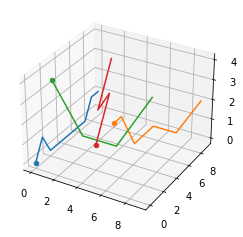


Statistics
  status   : OPTIMAL
  conflicts: 0
  branches : 0
  wall time: 5.712360433000001 s


In [439]:
CP = CPSolver(nrAirplanes,size,time,start,destination)
print('Adding constraints...')
CP.addConstraints()
print('Creating cost function...')
CP.model.Minimize(costFunction(CP.qbits) - 1000 * reward(CP.qbits))
print('Solving...')
# Creates a solver and solves the model.
solver = cp_model.CpSolver()
status = solver.Solve(CP.model)

if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    CP.plotTrajectory(solver)
else:
    print('No solution found.')

# Statistics.
print('\nStatistics')
print(f'  status   : {solver.StatusName(status)}')
print(f'  conflicts: {solver.NumConflicts()}')
print(f'  branches : {solver.NumBranches()}')
print(f'  wall time: {solver.WallTime()} s')


In [ ]:
def createMap(model,time,size_x,size_y):
    T = []
    for t in range(time):
        X = []
        for x in range(size_x):
            Y = []
            for y in range(size_y):
                 Y.append(model.NewIntVar(0, 1, 't%ix%iy%i' %(t,x,y)))
            X.append(Y)
        T.append(X)
    return T
            
                     


In [ ]:
def possibleTrajectory(model,qbits):
        for t in range(time-1):
            for x in range(size_x):
                for y in range(size_y):
                    if [x,Sy] != destination:
                        model.Add(qbits[t][x][y] == ( 
                            qbits[t+1][x][y]
                            + qbits[t+1][min(size_x,x+1)][y] 
                            + qbits[t+1][max(0,x-1)][y] 
                            + qbits[t+1][x][min(size_y,y+1)]
                            + qbits[t+1][x][max(0,y-1)]))
    

In [24]:
createMap(4,4,4)

[[[t0x0y0(0..1), t0x0y1(0..1), t0x0y2(0..1), t0x0y3(0..1)],
  [t0x1y0(0..1), t0x1y1(0..1), t0x1y2(0..1), t0x1y3(0..1)],
  [t0x2y0(0..1), t0x2y1(0..1), t0x2y2(0..1), t0x2y3(0..1)],
  [t0x3y0(0..1), t0x3y1(0..1), t0x3y2(0..1), t0x3y3(0..1)]],
 [[t1x0y0(0..1), t1x0y1(0..1), t1x0y2(0..1), t1x0y3(0..1)],
  [t1x1y0(0..1), t1x1y1(0..1), t1x1y2(0..1), t1x1y3(0..1)],
  [t1x2y0(0..1), t1x2y1(0..1), t1x2y2(0..1), t1x2y3(0..1)],
  [t1x3y0(0..1), t1x3y1(0..1), t1x3y2(0..1), t1x3y3(0..1)]],
 [[t2x0y0(0..1), t2x0y1(0..1), t2x0y2(0..1), t2x0y3(0..1)],
  [t2x1y0(0..1), t2x1y1(0..1), t2x1y2(0..1), t2x1y3(0..1)],
  [t2x2y0(0..1), t2x2y1(0..1), t2x2y2(0..1), t2x2y3(0..1)],
  [t2x3y0(0..1), t2x3y1(0..1), t2x3y2(0..1), t2x3y3(0..1)]],
 [[t3x0y0(0..1), t3x0y1(0..1), t3x0y2(0..1), t3x0y3(0..1)],
  [t3x1y0(0..1), t3x1y1(0..1), t3x1y2(0..1), t3x1y3(0..1)],
  [t3x2y0(0..1), t3x2y1(0..1), t3x2y2(0..1), t3x2y3(0..1)],
  [t3x3y0(0..1), t3x3y1(0..1), t3x3y2(0..1), t3x3y3(0..1)]]]